In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/train_FD001.txt', sep=" ", header=None)
df.head()
Y_data = pd.read_csv('/content/RUL_FD001.txt', sep=" ", header=None)
Y_data.drop(1,axis=1,inplace=True)
Y_list = Y_data.values.flatten().tolist()

In [3]:
df = df.drop([26,27], axis=1)
column_names = ["unit_number","time_in_cycles","setting1","setting2","setting3",
                "s01","s02","s03","s04","s05","s06","s07","s08","s09","s10","s11","s12",
                "s13","s14","s15","s16","s17","s18","s19","s20","s21"]
df.columns = column_names
df.head()

,unit_number,time_in_cycles,setting1,setting2,setting3,s01,s02,s03,s04,s05,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
#Use describe() to get summary statistics including standard deviation
description = df.describe()
# Filtering columns with nearly zero standard deviation
columns_with_low_std = description.columns[description.loc['std'] < 0.01]
print("Columns with nearly zero standard deviation:",columns_with_low_std)

#dropping coluums
df.drop(columns_with_low_std, axis=1, inplace=True)


Columns with nearly zero standard deviation: Index(['setting1', 'setting2', 'setting3', 's01', 's05', 's06', 's10', 's16',
       's18', 's19'],
      dtype='object')


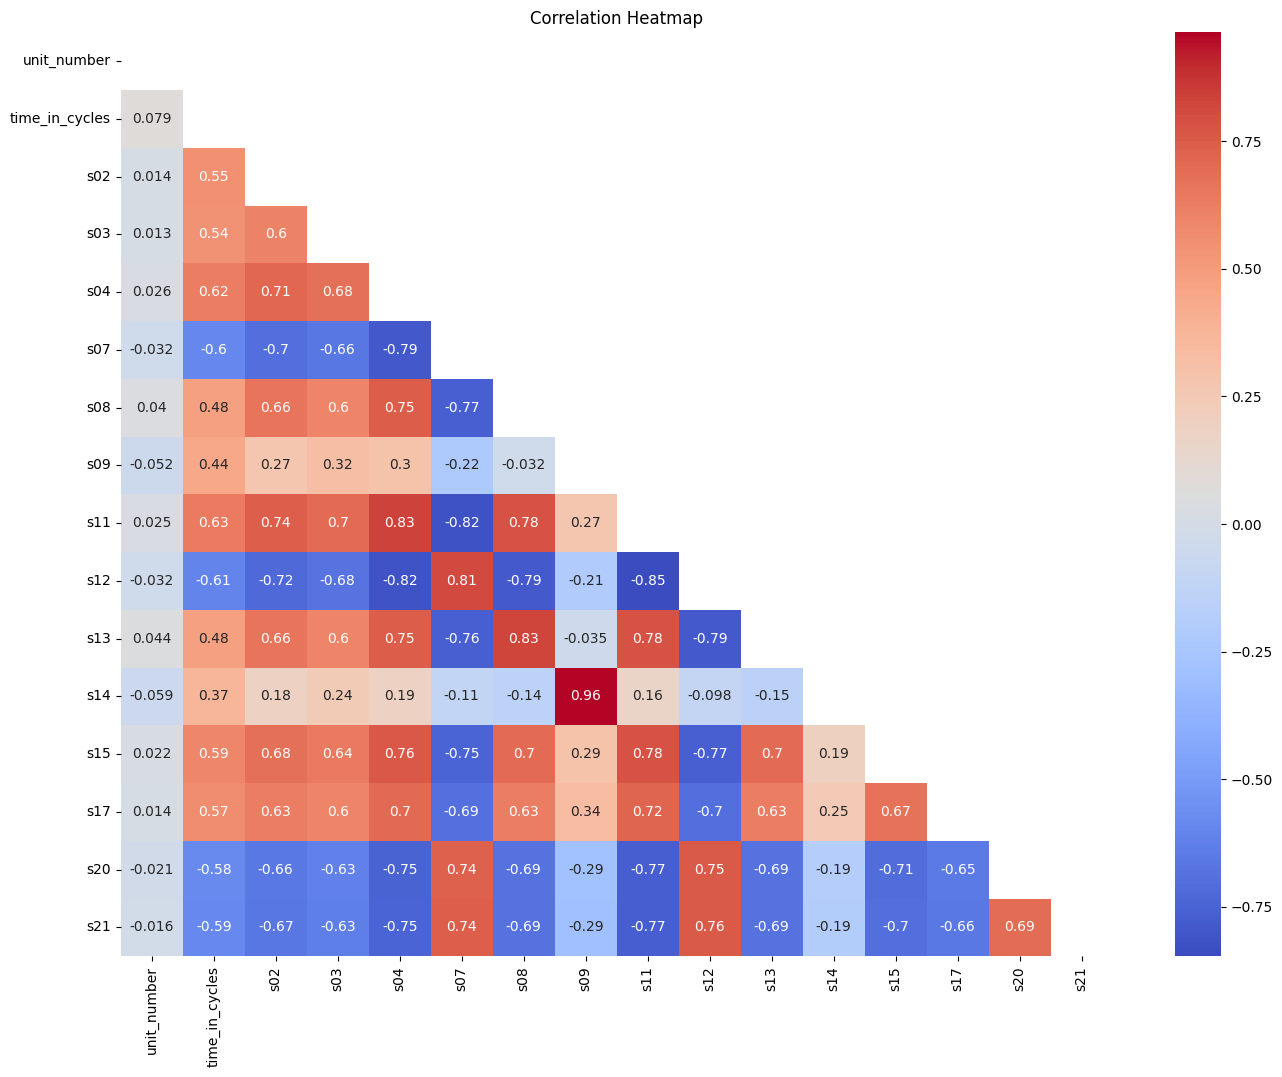

Columns dropped due to high correlation:
{'s09', 's14'}


In [5]:

columns_to_drop = set()
def find_correlated_columns(df, threshold=0.9, show_plot=False):

    # Compute the correlation matrix
    corr_matrix = df.corr()

    # Step 3: Identify highly correlated columns
    # Create a mask to ignore self-correlations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot the heatmap if show_plot is True
    if show_plot:
        plt.figure(figsize=(16, 12))
        sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.show()

    # Find pairs of highly correlated columns
    highly_correlated_pairs = [
        (col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns
        if corr_matrix.loc[col1, col2] > threshold and col1 != col2
    ]

    # Step 4: Drop one column from each pair of highly correlated columns

    for col1, col2 in highly_correlated_pairs:
        # Add one of the columns to the set of columns to drop
        columns_to_drop.add(col2)

    print("Columns dropped due to high correlation:")
    print(columns_to_drop)

    # Drop the identified columns
    df = df.drop(columns=list(columns_to_drop), axis=1)

    return df

df_cleaned = find_correlated_columns(df, show_plot=True)

In [6]:

df_cleaned['RUL'] = 0

for i in range(len(Y_data)):
    unit_number = i + 1
    rul_value = Y_data.iloc[i, 0]
    df_cleaned.loc[df_cleaned['unit_number'] == unit_number, 'RUL'] = rul_value




In [7]:
# Separate the target variable 'RUL' into Y
Y = df_cleaned['RUL']

# Separate the features into X
X = df_cleaned.drop(columns=['RUL'])



In [8]:

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Displaying the shapes of the resulting splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train length:", len(y_train))
print("y_test length:", len(y_test))

X_train shape: (16504, 14)
X_test shape: (4127, 14)
y_train length: 16504
y_test length: 4127


In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters found: {grid_search.best_params_}')

# Train the model with the best parameters and early stopping
best_params = grid_search.best_params_
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42,
                             **best_params)

# Fit the model with early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric="rmse",
              early_stopping_rounds=10,
              verbose=False)

# Evaluate the model
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'Train Mean Squared Error with early stopping: {mse_train:.4f}')
print(f'Test Mean Squared Error with early stopping: {mse_test:.4f}')
print(f'Train R-squared with early stopping: {r2_train:.4f}')
print(f'Test R-squared with early stopping: {r2_test:.4f}')
print(f'Train Mean Absolute Error with early stopping: {mae_train:.4f}')
print(f'Test Mean Absolute Error with early stopping: {mae_test:.4f}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'subsample': 1.0}
Train Mean Squared Error with early stopping: 0.0140
Test Mean Squared Error with early stopping: 0.2705
Train R-squared with early stopping: 1.0000
Test R-squared with early stopping: 0.9998
Train Mean Absolute Error with early stopping: 0.0683
Test Mean Absolute Error with early stopping: 0.2062


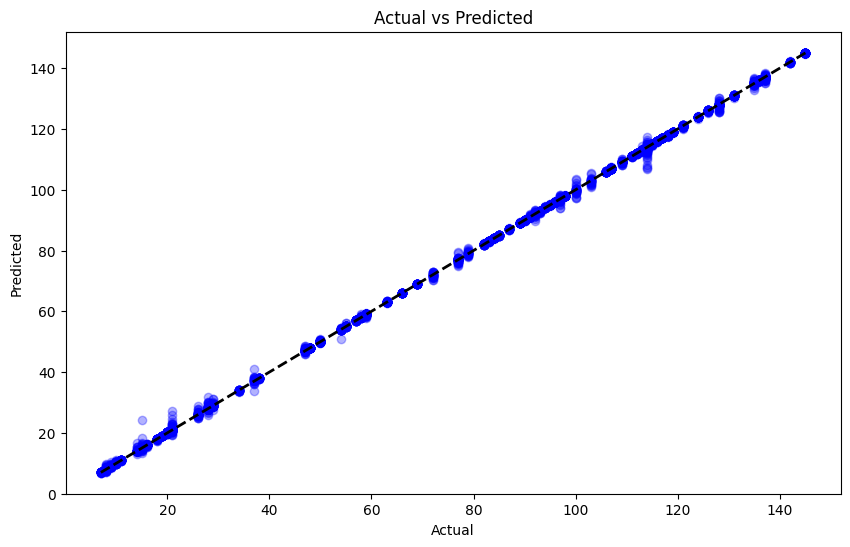

In [11]:
y_pred = xgb_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


In [12]:
df_test = pd.read_csv('/content/train_FD001.txt', sep=" ", header=None)
df_test.head()
df_test = df_test.drop([26,27], axis=1)
df_test.columns = column_names
df_test.drop(columns_with_low_std,axis=1,inplace=True)
df_test.drop(['s14','s09'],axis=1,inplace=True)

In [13]:
predicted = xgb_model.predict(df_test)

predicted_integers = list(map(int, predicted))

print(predicted_integers)

[111, 111, 112, 111, 111, 112, 111, 111, 111, 112, 111, 111, 112, 111, 111, 112, 111, 112, 111, 111, 112, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 111, 111, 111, 111, 111, 111, 111, 112, 112, 111, 111, 111, 111, 112, 111, 111, 111, 111, 112, 112, 112, 112, 111, 111, 112, 111, 111, 111, 112, 111, 112, 112, 111, 111, 111, 112, 112, 112, 111, 111, 111, 111, 112, 112, 112, 111, 111, 111, 112, 111, 111, 111, 111, 111, 111, 111, 112, 111, 111, 111, 111, 111, 112, 111, 111, 111, 111, 112, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 111, 111, 111, 112, 111, 111, 112, 111, 111, 112, 111, 111, 112, 111, 111, 111, 111, 112, 112, 111, 112, 111, 112, 112, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 98, 97, 97, 98, 98, 97, 97, 97, 98, 97,